In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp



# 0. Defining the converted first order ODE

In [25]:
def damped_oscillator(t, y, zeta): #defing the ODE system
    x, v = y
    dxdt = v
    dvdt = -2 * zeta * v - x
    return np.array([dxdt, dvdt])



# 1.1. Implementing Explicit Euler Method #

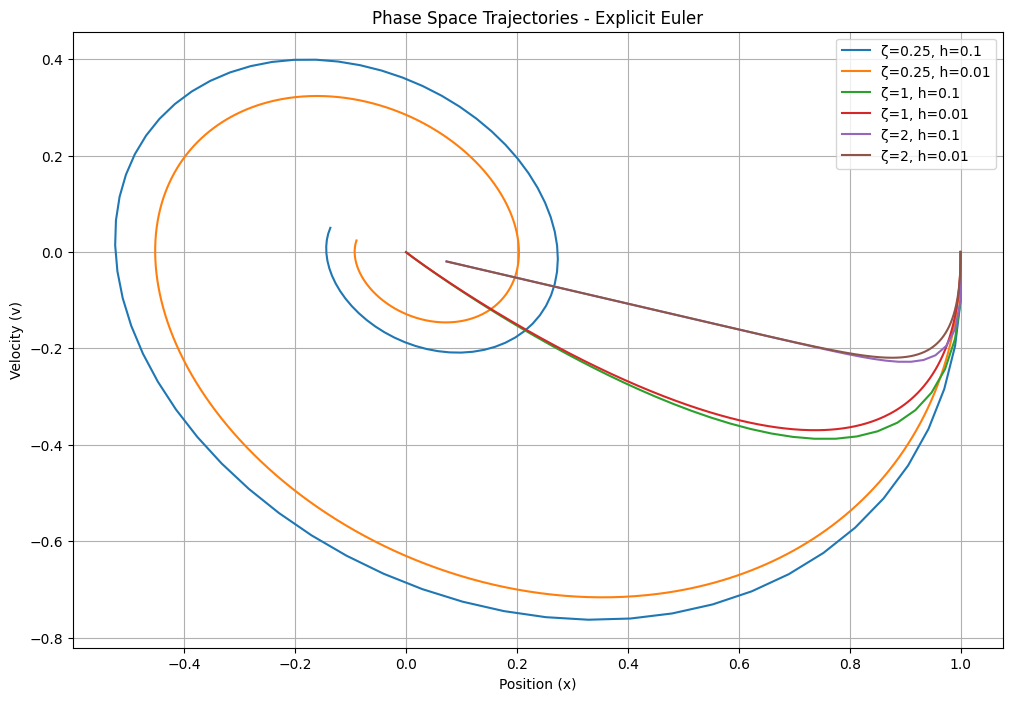

In [32]:
def explicit_euler(f, y0, t0, tf, h): #implementing explicit euler method
    t = np.arange(t0, tf, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(1, len(t)):
        y[i] = y[i-1] + h * f(t[i-1], y[i-1])
    return t, y

zeta_values = [0.25, 1, 2]
initial_conditions = [1, 0] #defing boundary conditions
t0, tf = 0, 10 #t-initial and t-final
h_values = [0.1, 0.01] #the order of magnitudes

solutions_explicit_euler = {}

for zeta in zeta_values:
    solutions_explicit_euler[zeta] = {}
    for h in h_values:
        t, y = explicit_euler(lambda t, y: damped_oscillator(t, y, zeta), initial_conditions, t0, tf, h)
        solutions_explicit_euler[zeta][h] = (t, y)

# Plot of the phase space trajectory for Explicit Euler

plt.figure(figsize=(12, 8))
for zeta in zeta_values:
    for h in h_values:
        t, y = solutions_explicit_euler[zeta][h]
        plt.plot(y[:, 0], y[:, 1], label=f'ζ={zeta}, h={h}')
plt.xlabel('Position (x)')
plt.ylabel('Velocity (v)')
plt.title('Phase Space Trajectories - Explicit Euler')
plt.legend()
plt.grid()
plt.show()

# 1.2. Implementing Implicit Euler Method

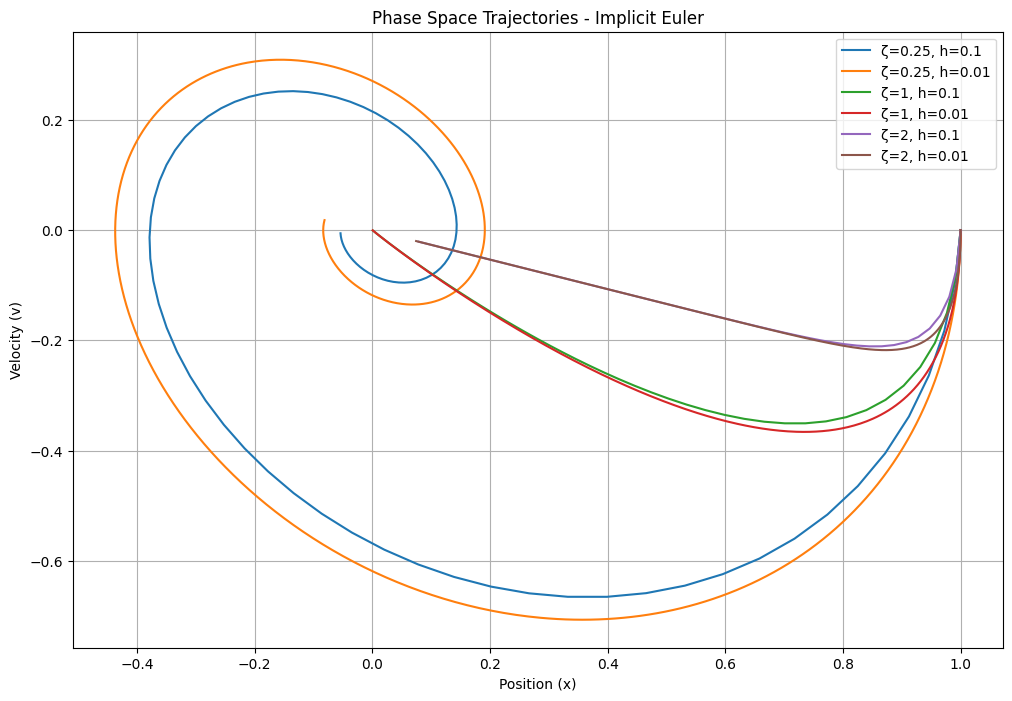

In [33]:



    def implicit_euler(f, y0, t0, tf, h): #implementing implicit euler method
        t = np.arange(t0, tf, h)
        y = np.zeros((len(t), len(y0)))
        y[0] = y0
        for i in range(1, len(t)):
            y_guess = y[i-1]  # Initial guess for implicit step
            for _ in range(10):  # Fixed-point iteration
                y_new = y[i-1] + h * f(t[i], y_guess)
                if np.linalg.norm(y_new - y_guess) < 1e-6:
                    break
                y_guess = y_new
            y[i] = y_new
        return t, y
    
    solutions_implicit_euler = {}
    
    for zeta in zeta_values:
        solutions_implicit_euler[zeta] = {}
        for h in h_values:
            t, y = implicit_euler(lambda t, y: damped_oscillator(t, y, zeta), initial_conditions, t0, tf, h)
            solutions_implicit_euler[zeta][h] = (t, y)
    
    # Plot of the phase space trajectory for Implicit Euler
    
    plt.figure(figsize=(12, 8))
    for zeta in zeta_values:
        for h in h_values:
            t, y = solutions_implicit_euler[zeta][h]
            plt.plot(y[:, 0], y[:, 1], label=f'ζ={zeta}, h={h}')
    plt.xlabel('Position (x)')
    plt.ylabel('Velocity (v)')
    plt.title('Phase Space Trajectories - Implicit Euler')
    plt.legend()
    plt.grid()
    plt.show()


# 1.3. Using the default SciPy built-in solver 

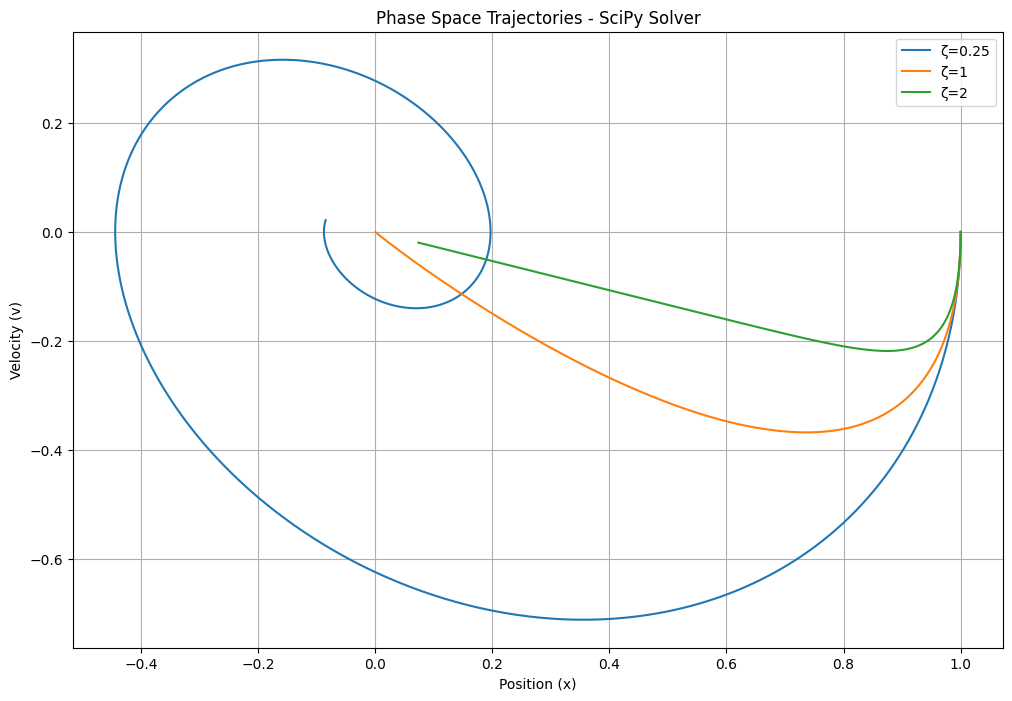

In [34]:

solutions_scipy = {}

for zeta in zeta_values:
    sol = solve_ivp(lambda t, y: damped_oscillator(t, y, zeta), [t0, tf], initial_conditions, method='RK45', t_eval=np.linspace(t0, tf, 1000))
    solutions_scipy[zeta] = sol

# Plot of the phase space trajectory for SciPy solver

plt.figure(figsize=(12, 8))
for zeta in zeta_values:
    sol = solutions_scipy[zeta]
    plt.plot(sol.y[0], sol.y[1], label=f'ζ={zeta}')
plt.xlabel('Position (x)')
plt.ylabel('Velocity (v)')
plt.title('Phase Space Trajectories - SciPy Solver')
plt.legend()
plt.grid()
plt.show()


# 2. Plotting phase space trajectories from all of the above method to compare 

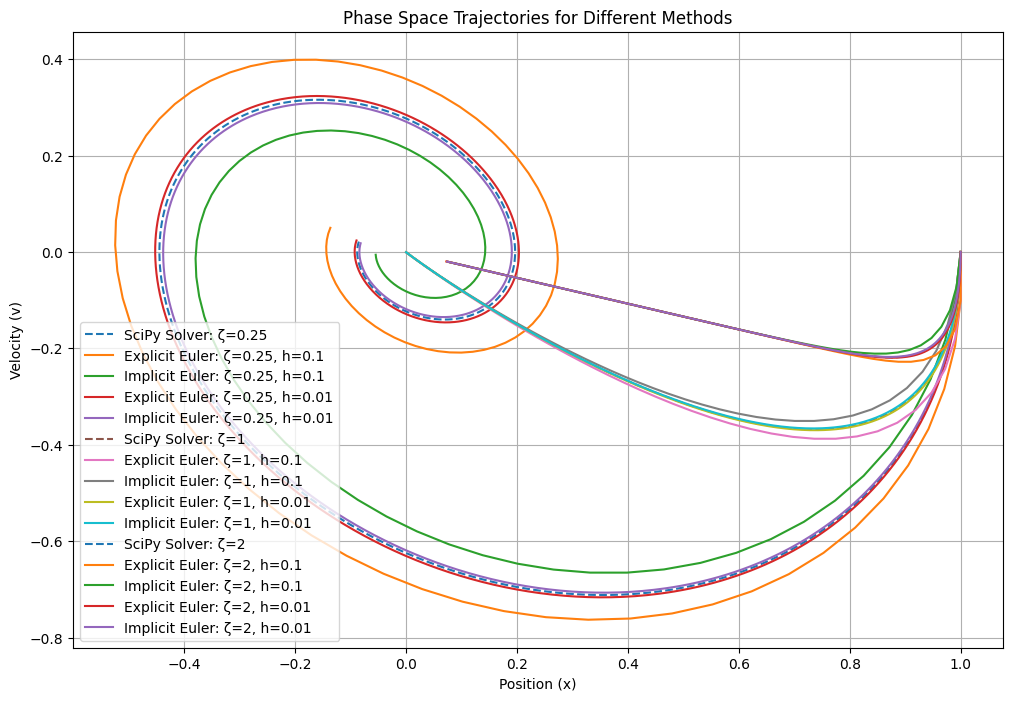

In [35]:

plt.figure(figsize=(12, 8))
for zeta in [0.25, 1, 2]:
    sol = solutions_scipy[zeta]
    plt.plot(sol.y[0], sol.y[1], label=f'SciPy Solver: ζ={zeta}', linestyle='--')
    for h in [0.1, 0.01]:
        t_exp, y_exp = explicit_euler(lambda t, y: damped_oscillator(t, y, zeta), [1, 0], 0, 10, h)
        t_imp, y_imp = implicit_euler(lambda t, y: damped_oscillator(t, y, zeta), [1, 0], 0, 10, h)
        plt.plot(y_exp[:, 0], y_exp[:, 1], label=f'Explicit Euler: ζ={zeta}, h={h}')
        plt.plot(y_imp[:, 0], y_imp[:, 1], label=f'Implicit Euler: ζ={zeta}, h={h}')
plt.xlabel('Position (x)')
plt.ylabel('Velocity (v)')
plt.title('Phase Space Trajectories for Different Methods')
plt.legend()
plt.grid()
plt.show()


# 3. Determining the order of each method by plotting the error vs step size on a log-log scale

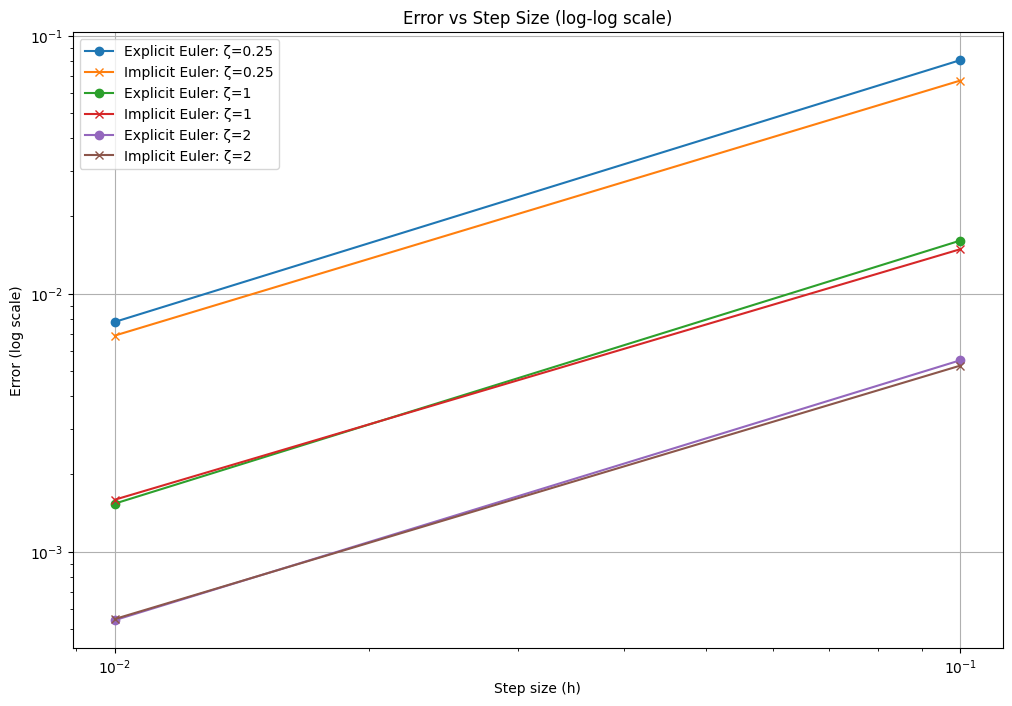

In [4]:
# Calculate error for different step sizes
errors_explicit_euler = {}
errors_implicit_euler = {}

for zeta in zeta_values:
    t_ref, y_ref = solutions_scipy[zeta].t, solutions_scipy[zeta].y.T
    errors_explicit_euler[zeta] = []
    errors_implicit_euler[zeta] = []
    for h in h_values:
        t_exp, y_exp = solutions_explicit_euler[zeta][h]
        t_imp, y_imp = solutions_implicit_euler[zeta][h]
        y_ref_interp_exp = np.interp(t_exp, t_ref, y_ref[:, 0])
        y_ref_interp_imp = np.interp(t_imp, t_ref, y_ref[:, 0])
        error_exp = np.linalg.norm(y_exp[:, 0] - y_ref_interp_exp, ord=np.inf)
        error_imp = np.linalg.norm(y_imp[:, 0] - y_ref_interp_imp, ord=np.inf)
        errors_explicit_euler[zeta].append(error_exp)
        errors_implicit_euler[zeta].append(error_imp)

# Plot error vs step size on log-log scale
plt.figure(figsize=(12, 8))
for zeta in zeta_values:
    plt.loglog(h_values, errors_explicit_euler[zeta], label=f'Explicit Euler: ζ={zeta}', marker='o')
    plt.loglog(h_values, errors_implicit_euler[zeta], label=f'Implicit Euler: ζ={zeta}', marker='x')
plt.xlabel('Step size (h)')
plt.ylabel('Error (log scale)')
plt.title('Error vs Step Size (log-log scale)')
plt.legend()
plt.grid()
plt.show()
